### CNN 2nd Version - Grayscale
- Applying grayscale on inputs and keep everything else the same as v2

In [2]:
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers
import keras_tuner as kt

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# plots
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [4]:
with open("../data/processed/processed_sub_dataset.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())

# load data for 10 subclasses
X_train = data['X_train_sub'] 
y_train = data['y_train_sub']
X_val = data['X_val_sub']
y_val = data['y_val_sub']
X_test = data['X_test_sub']
y_test = data['y_test_sub']

breed = data['classes_sub']
breed_ids = [i for i in range(len(breed))]
breed_id_map = {breed[i]:i for i in range(len(breed))}
id_breed_map = {id: label for label, id in breed_id_map.items()}
y_train = np.array([breed_id_map[x] for x in y_train])
y_val = np.array([breed_id_map[x] for x in y_val])
y_test = np.array([breed_id_map[x] for x in y_test])

# Grey-scale
def to_grayscale(X):
    X = tf.image.rgb_to_grayscale(X)
    return X

X_train_gray = to_grayscale(X_train)
X_val_gray = to_grayscale(X_val)
X_test_gray = to_grayscale(X_test)

print(breed)

dict_keys(['X_train_sub', 'y_train_sub', 'X_val_sub', 'y_val_sub', 'X_test_sub', 'y_test_sub', 'classes_sub'])
['flat' 'german_short' 'american_staffordshire_terrier' 'ibizan_hound'
 'cairn' 'kerry_blue_terrier' 'maltese_dog' 'bedlington_terrier'
 'english_setter' 'sussex_spaniel']


In [6]:
# Check size
print(f"X_train shape: {X_train_gray.shape}")
print(f"X_val shape: {X_val_gray.shape}")
print(f"X_test shape: {X_test_gray.shape}")
print(f"First 5 breeds in train: {y_train[:5]}")

X_train shape: (1000, 64, 64, 1)
X_val shape: (388, 64, 64, 1)
X_test shape: (390, 64, 64, 1)
First 5 breeds in train: [3 8 1 7 4]


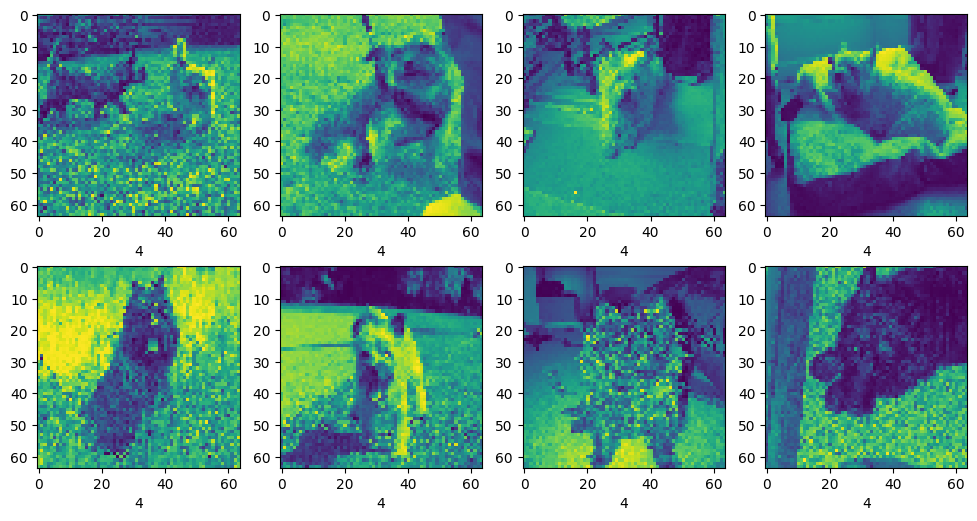

In [8]:
cols = 4
ind = [i for i, val in enumerate(y_train) if val == breed_id_map['cairn']]
plt.figure(figsize=(cols * 3, 6)) 
for i in range(8):
    plt.subplot(2, cols, i + 1)
    plt.grid(False)
    img = array_to_img(X_train_gray[ind[i]])
    plt.imshow(img)
    plt.xlabel(y_train[ind[i]])
plt.show()

Transformation and augmentation
- flip left and right - Dog images are usually symmetric, so flipping is safe
- random room in - Adds robustness to zoom
- Color and Lighting - ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)

### Use a basic CNN architecture and keras.tuner

In [ ]:
def preprocess_data_part(X_train, delta=0.2):
    """ apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    """
    # tf.random.set_seed(42)
    # np.random.seed(42)
    
    # image augmentation - 1. random flip
    X_train_flip = tf.image.flip_left_right(X_train) 
    
    # image augmentation - 2. random rotation
    rotation_layer = tf.keras.layers.RandomRotation(factor=0.5)
    X_train_rotate = rotation_layer(X_train_flip, training=True)

    # image augmentation - 3. adjusting color
    X_train_color = tf.image.random_brightness(X_train_rotate, max_delta=delta)
    X_train_color = tf.image.random_contrast(X_train_color, lower=1 - delta, upper=1 + delta)
    X_train_color = tf.image.random_saturation(X_train_color, lower=1 - delta, upper=1 + delta)

    # image augmentation - 3. crop
    X_train_resize = []
    for i in range(X_train_color.shape[0]):
        random_size = tf.random.uniform((2,), minval=48, maxval=64, dtype=tf.int32)
        X_train_resize.append([tf.image.resize(tf.image.random_crop(value=X_train_color[i], size=(random_size[0], random_size[1], X_train_color.shape[-1])), (64, 64))])

    X_aug_res = np.concatenate(X_train_resize, axis=0)

    return X_aug_res


X_augs = [X_train_gray]
Y_augs = [y_train_gray]
for _ in range(29):
    Xa = preprocess_data_part(X_train_gray)
    X_augs.append(Xa)
    Y_augs.append(y_train_gray)

# concatenate original X_train and augmented X_train_augm data
X_train_aug = np.concatenate(X_augs, axis=0)
# concatenate y_train (note the label is preserved)
y_train_aug = tf.concat(Y_augs, axis=0)

# shuffle X_train and y_train, i.e., shuffle two tensors in the same order
shuffle = tf.random.shuffle(tf.range(tf.shape(X_train_aug)[0], dtype=tf.int32))
X_train_aug = tf.gather(X_train_aug, shuffle).numpy() # transform X back to numpy array instead of tensor
y_train_aug = tf.gather(y_train_aug, shuffle).numpy() # transform y back to numpy array instead of tensor

print(X_train_aug.shape)
print(y_train_aug.shape)

(30000, 64, 64, 3)
(30000,)


In [60]:
unique, counts = np.unique(y_val, return_counts=True)
print(unique, counts)
unique, counts = np.unique(y_train_aug, return_counts=True)
print(unique, counts)

[0 1 2 3 4 5 6 7 8 9] [26 26 32 44 48 40 76 41 30 25]
[0 1 2 3 4 5 6 7 8 9] [3000 3000 3000 3000 3000 3000 3000 3000 3000 3000]


In [ ]:
def model_builder_for_n_classes(num_classes = 10):
    def model_builder(hp):
        # initialize model
        tf.keras.backend.clear_session()
        random.seed(42)
        tf.random.set_seed(42)
        np.random.seed(42)
        
        model = tf.keras.Sequential()

        # add convolutional layer with hyperparameters from 1st version
        model.add(tf.keras.layers.Conv2D(
            filters=16,
            kernel_size=(2, 2),
            activation='tanh',
            padding='same',
            input_shape=(64, 64, 3)
        ))
        
        model.add(tf.keras.layers.MaxPooling2D(pool_size=4))

        model.add(tf.keras.layers.Dropout(rate=0.4))

        hp_filters = hp.Int('filters', min_value=4, max_value=16, step=4)
        hp_kernel_size = hp.Int('kernel_size', min_value=2, max_value=6, step=2)
        kernel_tuple = (hp_kernel_size, hp_kernel_size)
        hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

        model.add(tf.keras.layers.Conv2D(
            filters=hp_filters,
            kernel_size=kernel_tuple,
            activation=hp_activation,
            padding='same'
            # input_shape=(64, 64, 3)
        ))
        
        hp_pool = hp.Int('pool_size', min_value=2, max_value=4, step=1)
        model.add(tf.keras.layers.MaxPooling2D(pool_size=hp_pool))

        hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
        model.add(tf.keras.layers.Dropout(rate=hp_dropout))

        model.add(tf.keras.layers.Flatten())

        model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

        # build and compile model
        model.build(input_shape=(None, 64, 64, 3))
        hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

        return model
    return model_builder

In [14]:
tuner = kt.RandomSearch(
    model_builder_for_n_classes(10),
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='cnn_tuning',
    overwrite=True
)

tuner.search_space_summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True)

tuner.search(
    X_train_aug, y_train_aug,  # make sure this is integer encoded
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Trial 20 Complete [00h 00m 11s]
val_accuracy: 0.24742268025875092

Best val_accuracy So Far: 0.4201031029224396
Total elapsed time: 00h 06m 36s


In [15]:
# get the hyperparamers from the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

filters: 16
kernel_size: 6
activation: tanh
pool_size: 2
dropout: 0.5
learning_rate: 0.001


In [16]:
best_model = tuner.get_best_models(num_models=1)[0]
train_acc = best_model.evaluate(X_train_aug, y_train_aug, verbose=0)[1]
val_acc = best_model.evaluate(X_val, y_val, verbose=0)[1]

print("Best model summary:")
print(best_model.summary())
print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

/home/lyn/miniconda3/envs/dev/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 16)     │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,690 (76.91 KB)

 Trainable params: 19,690 (76.91 KB)

 Non-trainable params: 0 (0.00 B)

None
Train Accuracy: 0.6693, Validation Accuracy: 0.4201


### Use a more complex CNN architecture and tune it manually

In [ ]:
# initialize model
class ManualCNN(tf.keras.Model):
    def __init__(self, num_classes=10):
        super().__init__()

        self.preproc = tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal"),
                tf.keras.layers.RandomRotation(0.5),
                tf.keras.layers.RandomZoom(0.2),
                tf.keras.layers.RandomCrop(64, 64),
                tf.keras.layers.RandomBrightness(0.2, (0.0, 1.0)),
                tf.keras.layers.RandomContrast(0.2),
            ])

        self.conv1 = tf.keras.layers.Conv2D(8, (8, 8), activation='tanh', padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(0.01, 0.01))
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=(2, 2), padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(16, (4, 4), activation='tanh', padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(0.01, 0.01))
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=(2, 2), padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv2D(16, (2, 2), activation='tanh', padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(0.01, 0.01))
        self.conv4 = tf.keras.layers.Conv2D(16, (2, 2), activation='tanh', padding='same',
                                            kernel_regularizer=tf.keras.regularizers.L1L2(0.01, 0.01))
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=(2, 2), padding='same')

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(128, activation='tanh')
        self.fc2 = tf.keras.layers.Dense(128, activation='tanh')
        self.dropout = tf.keras.layers.Dropout(0.25)
        self.out = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        if training:
            x = self.preproc(inputs, training=True)
        else:
            x = inputs
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.bn1(x, training=training)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.bn2(x, training=training)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.dropout(x, training=training)
        return self.out(x)

Epoch 1/300


I0000 00:00:1753330785.606487  984192 cuda_dnn.cc:529] Loaded cuDNN version 90300


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.1131 - loss: 6.4850 - val_accuracy: 0.2577 - val_loss: 5.2086
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.1713 - loss: 5.0873 - val_accuracy: 0.2242 - val_loss: 4.3545
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1859 - loss: 4.1861 - val_accuracy: 0.1907 - val_loss: 3.8000
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1952 - loss: 3.5849 - val_accuracy: 0.0670 - val_loss: 3.4555
Epoch 5/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.1827 - loss: 3.1787 - val_accuracy: 0.1830 - val_loss: 3.0452
Epoch 6/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2053 - loss: 2.9222 - val_accuracy: 0.0902 - val_loss: 2.9322
Epoch 7/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2068 - loss: 2.6800 - val_accuracy: 0.1366 - val_loss: 2.6649
Epoch 8/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2234 - loss: 2.5368 - val_accuracy: 0.1366 - val_

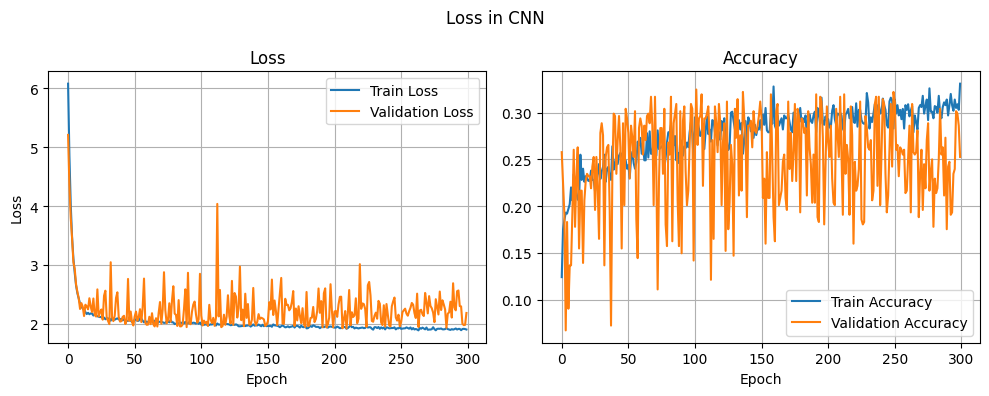

Train Accuracy: 0.3310, Validation Accuracy: 0.2526


In [12]:
tf.keras.backend.clear_session()
model = ManualCNN(num_classes=10)

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    X_train_gray, y_train,
    validation_data=(X_val_gray, y_val),
    epochs=300,
    batch_size=16,
    verbose=1
)

# # history = best_model.fit(
# #     X_train_aug, y_train_aug,
# #     validation_data=(X_val, y_val),
# #     epochs=50,
# #     verbose=1)

# plot loss curves
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Plot Train Loss
axes[0].plot(history.history['loss'], label='Train Loss', color='tab:blue')
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='tab:orange')
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# Plot Validation Loss
axes[1].plot(history.history['accuracy'], label='Train Accuracy', color='tab:blue')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:orange')
axes[1].set_title("Accuracy")  
axes[1].set_xlabel("Epoch")
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Loss in CNN", fontsize=12)
plt.tight_layout()
plt.show()

# evaluate the accuracy of model_tf on (X_train, y_train) and (X_val, y_val)
train_acc = history.history['accuracy'][-1]
val_acc =  history.history['val_accuracy'][-1]
print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

In [13]:
predicted_val = model.predict(X_val)
predicted_labels = [np.argmax(predicted_val[i]) for i in range(predicted_val.shape[0])]

# plot confusion matrix
cm = confusion_matrix(y_val, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=breed)
disp.plot()
plt.title('Confusion Matrix')
plt.xticks(rotation=80)
plt.show()

ValueError: Exception encountered when calling ManualCNN.call().

[1mInput 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (32, 64, 64, 3)[0m

Arguments received by ManualCNN.call():
  • inputs=tf.Tensor(shape=(32, 64, 64, 3), dtype=float32)
  • training=False

In [180]:
mistakes = cm.sum(axis=1) - np.diag(cm)
pd.DataFrame(mistakes, columns=['mistakes'], index = breed).sort_values(by=['mistakes'], ascending=False)

,mistakes
cairn,44
maltese_dog,43
ibizan_hound,34
american_staffordshire_terrier,29
kerry_blue_terrier,27
english_setter,24
bedlington_terrier,20
german_short,20
sussex_spaniel,17
flat,8


In [173]:
cm

array([[18,  1,  1,  1,  0,  5,  0,  0,  0,  0],
       [ 7,  6,  3,  1,  1,  2,  2,  2,  2,  0],
       [ 9,  3,  3,  3,  0,  2,  1,  7,  2,  2],
       [ 0,  2,  4, 10,  0,  1,  8, 11,  7,  1],
       [ 6, 10,  3,  0,  4,  5,  5, 10,  3,  2],
       [14,  5,  1,  1,  1, 13,  0,  3,  1,  1],
       [ 0,  0,  2,  5,  3,  1, 33, 23,  8,  1],
       [ 0,  2,  3,  0,  1,  3, 10, 21,  1,  0],
       [ 0,  0,  6,  3,  1,  1,  3,  9,  6,  1],
       [ 4,  1,  2,  2,  2,  4,  1,  0,  1,  8]])

In [ ]:
# learn 